In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae
from model.vae import *

from dataset import hhRNA1, hhATAC1

from utils import *
from model.loss import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
symsim_r1b1 = hhRNA1(standardize=False, rna_seq_file = "./data/human_hematopoiesis/count_rna.csv", rna_celltype_file = "./data/human_hematopoiesis/celltypes_rna.txt")
symsim_r1b2 = hhATAC1(standardize=False, atac_seq_file = "./data/human_hematopoiesis/count_atac.csv", atac_celltype_file = "./data/human_hematopoiesis/celltypes_atac.txt")

symsim_r1b1_CONFIG = { 
    'in_features': 500,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 32,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

symsim_r1b2_CONFIG = { 
    'in_features': 1764,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 32,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}


train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_r1b1_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_r1b2_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    Diff1 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 5, 
                                  t = 6, 
                                  use_potential = True)
    
    DPT1 = diff.DPT_similarity(data["raw"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    
    DPT1 = torch.FloatTensor(DPT1).to(device)


for data in test_r1b2_loader:
    Diff2 = diff.phate_similarity(data["raw"], 
                                  n_neigh = 5, 
                                  t = 6, 
                                  use_potential = True)
    
    DPT2 = diff.DPT_similarity(data["raw"], 
                               n_neigh = 5, 
                               use_potential = True)
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    
    DPT2 = torch.FloatTensor(DPT2).to(device)

In [3]:
def traj_loss_vae(recon_x, x, z, muz, logvarz, diff_sim, lamb_recon = 1, lamb_dist = 1, beta = 0.01, recon_mode = "original"):

    if recon_mode == "original":
        loss_recon = lamb_recon * F.mse_loss(recon_x, x)
    elif recon_mode == "relative":
        mean_recon = torch.mean(recon_x, dim = 0)
        var_recon = torch.var(recon_x, dim = 0)
        mean_x = torch.mean(x, dim = 0)
        var_x = torch.var(x, dim = 0)
        # relative loss
        loss_recon = lamb_recon * F.mse_loss(torch.div(torch.add(x, -1.0 * mean_x), (torch.sqrt(var_x + 1e-12)+1e-12)), torch.div(torch.add(x, -1.0 * mean_recon), (torch.sqrt(var_recon + 1e-12)+1e-12)))
    else:
        raise ValueError("recon_mode can only be original or relative")

    # cosine similarity loss
    latent_sim = pairwise_distance(muz)
        
    # normalize latent similarity matrix
    latent_sim = latent_sim / torch.norm(latent_sim, p='fro')
    diff_sim = diff_sim / torch.norm(diff_sim, p = 'fro')

    # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
    loss_dist = - lamb_dist * torch.sum(diff_sim * latent_sim) 
    
    # kl loss
    loss_kl = beta * 0.5 * torch.sum(- logvarz + torch.exp(logvarz) + muz * muz - 1)

    loss = loss_recon + loss_dist + loss_kl
    return loss, loss_recon, loss_dist, loss_kl

In [10]:
def train_unpaired_vae(model_rna, model_atac, disc, data_loader_rna, data_loader_atac, diff_sim_rna, diff_sim_atac, optimizer_rna, optimizer_atac, optimizer_D, n_epochs = 50, lamb_r = 1, lamb_d = 1, beta = 0.01):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    for epoch in range(n_epochs):
        for data in zip(data_loader_rna, data_loader_atac):
            # Update RNA Encoder
            data_rna, data_atac = data
            batch_cols_rna = data_rna['index'].to(device)
            batch_sim_rna = diff_sim_rna[batch_cols_rna,:][:,batch_cols_rna]
            batch_expr_rna = data_rna['count'].to(device)

            batch_expr_r_rna, z_rna, muz_rna, logvarz_rna = model_rna(batch_expr_rna)
    
            train_loss_rna, loss_recon_rna, loss_dist_rna, loss_kl_rna = traj_loss_vae(recon_x = batch_expr_r_rna, x = batch_expr_rna, z = z_rna, muz = muz_rna, logvarz = logvarz_rna, diff_sim = batch_sim_rna, lamb_recon = lamb_r, lamb_dist = lamb_d, beta = beta, recon_mode = "relative")

            train_loss_rna.backward()
            optimizer_rna.step()
            optimizer_rna.zero_grad()

            # Update ATAC Encoder
            batch_cols_atac = data_atac['index'].to(device)
            batch_sim_atac = diff_sim_atac[batch_cols_atac,:][:,batch_cols_atac]
            batch_expr_atac = data_atac['count'].to(device)

            batch_expr_r_atac, z_atac, muz_atac, logvarz_atac = model_atac(batch_expr_atac)

            train_loss_atac, loss_recon_atac, loss_dist_atac, loss_kl_atac = traj_loss_vae(recon_x = batch_expr_r_atac, x = batch_expr_atac, z = z_atac, muz = muz_atac, logvarz = logvarz_atac, diff_sim = batch_sim_atac, lamb_recon = lamb_r, lamb_dist = lamb_d, beta = beta, recon_mode = "relative")

            train_loss_atac.backward()
            optimizer_atac.step()
            optimizer_atac.zero_grad()

            z_rna = model_rna(batch_expr_rna)[1]
            z_atac = model_atac(batch_expr_atac)[1]

            # Update Discriminator
            D_loss_avg = 0
            n_iter = 15
            n_rna = batch_cols_rna.shape[0]
            n_atac = batch_cols_atac.shape[0]
            # note that detach here is necessary, use directly will cause error in encoder update later
            input_disc = torch.cat((z_rna.detach(), z_atac.detach()), dim = 0)
            target = torch.cat((torch.full((n_rna, ), 0, dtype = torch.float), torch.full((n_atac, ), 1, dtype = torch.float))).to(device)
            

            for i in range(n_iter):
                output = disc(input_disc).squeeze()
                D_loss = F.binary_cross_entropy(output, target)
                D_loss_avg += D_loss.item()
                D_loss.backward()
                optimizer_D.step()
                optimizer_D.zero_grad()
            D_loss_avg /= n_iter

            # Update Encoder
            E_loss = -1 * F.binary_cross_entropy(disc(torch.cat((z_rna, z_atac), dim = 0)).squeeze(), target)
            E_loss.backward()
            optimizer_rna.step()
            optimizer_atac.step()
            optimizer_rna.zero_grad()
            optimizer_atac.zero_grad()

        if epoch % 10 == 0:
            log_rna = "RNA loss: {:.5f}, RNA recon loss: {:.5f}, RNA dist loss: {:.5f}, RNA kl loss: {:.5f}".format(train_loss_rna.item(), loss_recon_rna.item(), loss_dist_rna.item(), loss_kl_rna.item())
            log_atac = "ATAC loss: {:.5f}, ATAC recon loss: {:.5f}, ATAC dist loss: {:.5f}, ATAC kl loss: {:.5f}".format(train_loss_atac.item(), loss_recon_atac.item(), loss_dist_atac.item(), loss_kl_atac.item())
            log_D = "Discriminator loss: {:.5f}".format(D_loss_avg)
            print("epoch: ", epoch, log_rna, log_atac, log_D)

In [11]:
vae1 = vae(symsim_r1b1_CONFIG).to(device)
vae2 = vae(symsim_r1b2_CONFIG).to(device)

disc = ae.discriminator().to(device)

optimizer_rna = torch.optim.Adam(vae1.parameters(), lr = 5e-4)
optimizer_atac = torch.optim.Adam(vae2.parameters(), lr = 5e-4)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 5e-4)

# print(vae1)
# print(vae2)

In [12]:
train_unpaired_vae(vae1, vae2, disc, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, optimizer_rna, optimizer_atac, optimizer_D, n_epochs=101, lamb_r=1, lamb_d=1, beta=0.05)

epoch:  0 RNA loss: -0.45203, RNA recon loss: 0.26807, RNA dist loss: -0.87112, RNA kl loss: 0.15102 ATAC loss: -0.70590, ATAC recon loss: 0.20300, ATAC dist loss: -0.94739, ATAC kl loss: 0.03848 Discriminator loss: 0.68859
epoch:  10 RNA loss: -0.78225, RNA recon loss: 0.18158, RNA dist loss: -0.97246, RNA kl loss: 0.00863 ATAC loss: -0.86872, ATAC recon loss: 0.10653, ATAC dist loss: -0.98382, ATAC kl loss: 0.00856 Discriminator loss: 0.69614
epoch:  20 RNA loss: -0.79231, RNA recon loss: 0.17775, RNA dist loss: -0.98199, RNA kl loss: 0.01192 ATAC loss: -0.89962, ATAC recon loss: 0.07537, ATAC dist loss: -0.98091, ATAC kl loss: 0.00592 Discriminator loss: 0.69125
epoch:  30 RNA loss: -0.80975, RNA recon loss: 0.15727, RNA dist loss: -0.98046, RNA kl loss: 0.01344 ATAC loss: -0.90452, ATAC recon loss: 0.06976, ATAC dist loss: -0.98005, ATAC kl loss: 0.00576 Discriminator loss: 0.69301
epoch:  40 RNA loss: -0.81898, RNA recon loss: 0.15124, RNA dist loss: -0.98791, RNA kl loss: 0.01769

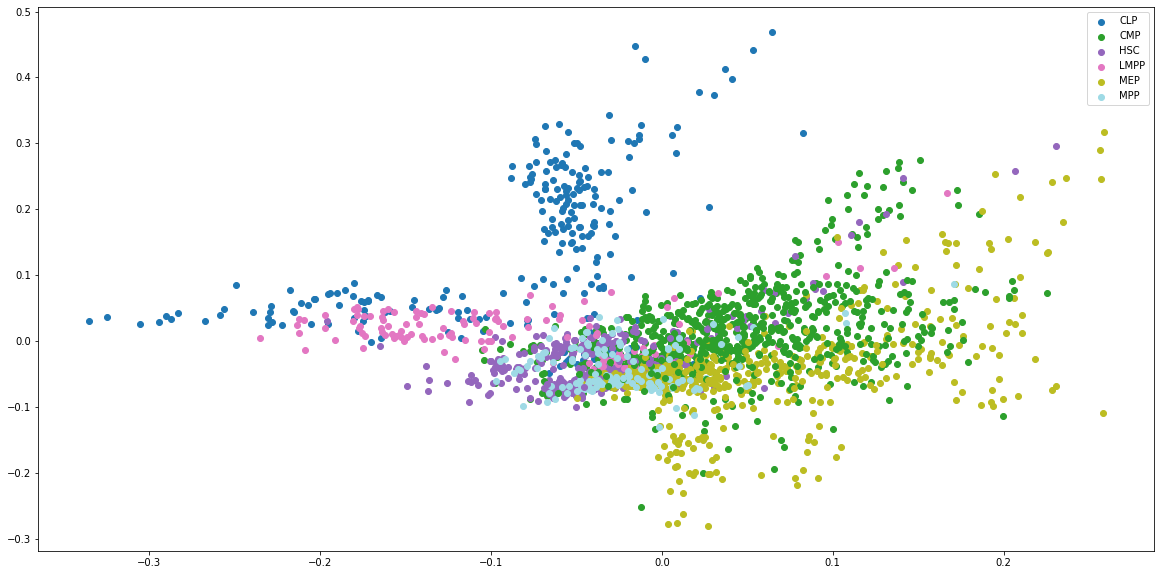

In [13]:
vae1.eval()
vae2.eval()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()

for data in test_r1b1_loader:
    ae_coordinates= vae1(data['count'].to(device))[1].cpu().detach().numpy()
cell_type = symsim_r1b1.cell_labels
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)


for data in test_r1b2_loader:
    ae_coordinates = vae2(data['count'].to(device))[1].cpu().detach().numpy()
cell_type = symsim_r1b2.cell_labels
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    ax.scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

ax.legend(cluster_types)
# fig.savefig("./result/hm/3/phate_backbones_t6_1.pdf")

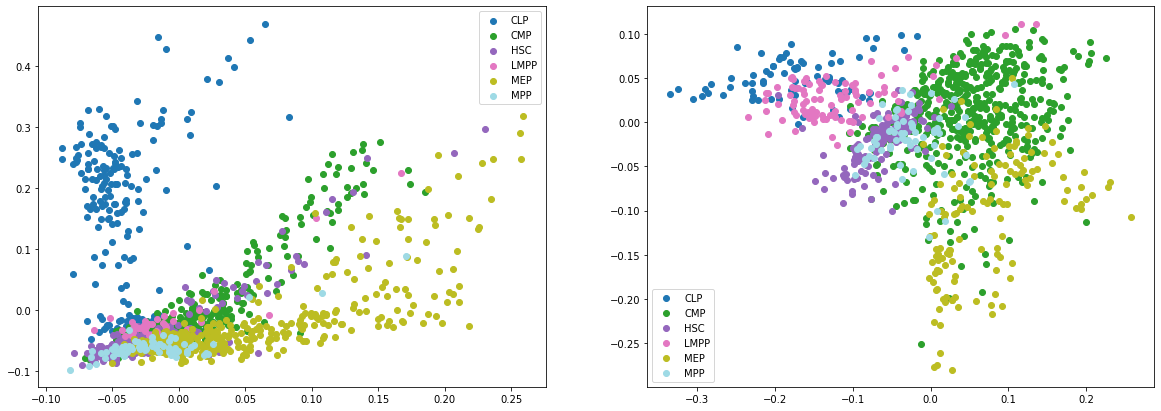

In [14]:
vae1.eval()
vae2.eval()
fig = plt.figure(figsize = (20,7))
axs = fig.subplots(1,2)

for data in test_r1b1_loader:
    ae_coordinates = vae1(data['count'].to(device))[1].cpu().detach().numpy()
cell_type = symsim_r1b1.cell_labels
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[0].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)
axs[0].legend(cluster_types)

for data in test_r1b2_loader:
    ae_coordinates = vae2(data['count'].to(device))[1].cpu().detach().numpy()
cell_type = symsim_r1b2.cell_labels
cluster_types = np.unique(cell_type)
colormap = plt.cm.get_cmap("tab20", cluster_types.shape[0])

for i, cluster_type in enumerate(cluster_types):
    index = np.where(cell_type == cluster_type)[0]
    axs[1].scatter(ae_coordinates[index,0], ae_coordinates[index,1], color = colormap(i), alpha = 1)

axs[1].legend(cluster_types)
# fig.savefig("./result/hm/3/phate_backbones_seperate_t6_1.pdf")

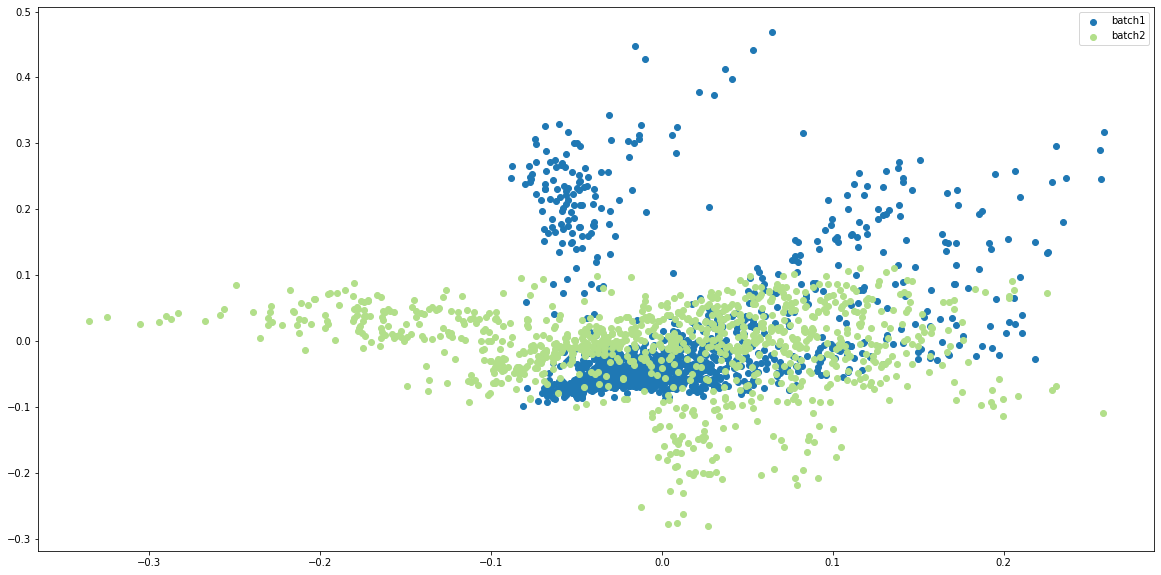

In [15]:
vae1.eval()
vae2.eval()
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
colormap = plt.cm.get_cmap("Paired")

for data in test_r1b1_loader:
    ae_coordinates = vae1(data['count'].to(device))[1].cpu().detach().numpy()

ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(1), label = "batch1", alpha = 1)

for data in test_r1b2_loader:
    ae_coordinates = vae2(data['count'].to(device))[1].cpu().detach().numpy()
ax.scatter(ae_coordinates[:,0], ae_coordinates[:,1], color = colormap(2), label = "batch2", alpha = 1)

ax.legend()
# fig.savefig("./result/hm/3/phate_backbones_merge_t6_1.pdf")